# Нейроинформатика. Лабораторная работа 3
### Линейная нейронная сеть. Правило обучения Уидроу-Хоффа

Целью работы является исследование свойств многослойной нейронной сети прямого распространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции.

Выполнил Моисеенков Илья, 408Б

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

### Задание 1

Попробуем применить многослойный перцептрон для классификации линейно неразделимых множеств

Сгенерируем датасет. Датасет будет состоять из точек, принадлежащим границам трех эллипсов

In [ ]:
ellipse0 = dict(
    a = 0.2,
    b = 0.2,
    alpha = 0,
    x0 = -0.25,
    y0 = 0.25,
    label = 0,
)

ellipse1 = dict(
    a = 0.7,
    b = 0.5,
    alpha = -np.pi / 3,
    x0 = 0,
    y0 = 0,
    label = 1,
)

ellipse2 = dict(
    a = 1,
    b = 1,
    alpha = 0,
    x0 = 0,
    y0 = 0,
    label = 2,
)

In [ ]:
def gen_dataset(ellipses):
    t = np.linspace(0, 2 * np.pi, int(2 * np.pi / 0.025))
    
    points = np.array([
        [
            ellipses[i]['a'] * np.cos(t) * np.cos(ellipses[i]['alpha']) \
            - ellipses[i]['b'] * np.sin(t) * np.sin(ellipses[i]['alpha']) \
            + ellipses[i]['x0'],
         
            ellipses[i]['a'] * np.cos(t) * np.sin(ellipses[i]['alpha']) \
            + ellipses[i]['b'] * np.sin(t) * np.cos(ellipses[i]['alpha']) \
            + ellipses[i]['y0'],

            np.tile(ellipses[i]['label'], len(t)),
        
         ] for i in range(len(ellipses))])
    
    np.random.seed(0xDEAD)

    el_0 = points[0, :, np.random.choice(len(t), 60, replace=False)]
    el_1 = points[1, :, np.random.choice(len(t), 100, replace=False)]
    el_2 = points[2, :, np.random.choice(len(t), 120, replace=False)]
    
    data = np.vstack((el_0, el_1, el_2))
    np.random.shuffle(data)

    return data

In [ ]:
data1 = gen_dataset([ellipse0, ellipse1, ellipse2])

In [ ]:
data1.shape

(280, 3)

Посмотрим на получившийся датасет

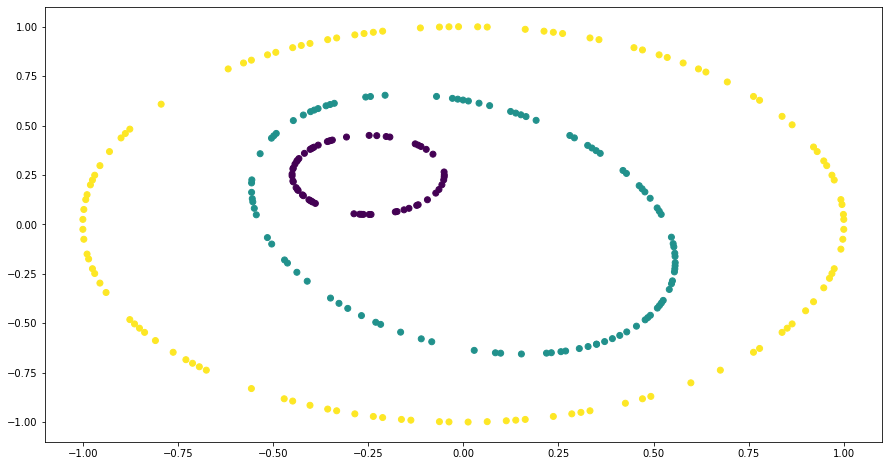

In [ ]:
plt.figure(figsize=(15, 8))

plt.scatter(data1[:, 0], data1[:, 1], c=data1[:, 2])

plt.show()

Поделим данные на трейн, тест и валидацию

In [ ]:
train, val, test = np.split(data1, [int(.7*len(data1)), int(.9*len(data1))])

In [ ]:
train.shape, val.shape, test.shape

((196, 3), (56, 3), (28, 3))

Отделим фичи от таргетов. X - фичи, y - таргеты

In [ ]:
X_train = train[:, :2]
y_train = train[:, 2]

X_test = test[:, :2]
y_test = test[:, 2]

X_val = val[:, :2]
y_val = val[:, 2]

Будем использовать двухслойный перцептрон. В скрытом слое по заданию будет 20 нейронов. В качестве функции активации будем использовать танх, алгоритм обучения - RMSProp

In [ ]:
model1 = keras.Sequential([
    keras.layers.Dense(20, activation='tanh'),
    keras.layers.Dense(3, activation='softmax'),
])

In [ ]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics='accuracy'
)

In [ ]:
train_info1 = model1.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=500,
    validation_data=(X_val, y_val),
    shuffle=True,
    verbose=0
)


Посмотрим на графики

In [ ]:
def plot_metrics(train_info):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    loss_history = train_info.history['loss']
    val_loss_history = train_info.history['val_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
    plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    acc_history = train_info.history['accuracy']
    val_acc_history = train_info.history['val_accuracy']
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.plot(range(1, len(acc_history) + 1), acc_history, label='train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Accuracy')

    plt.show()

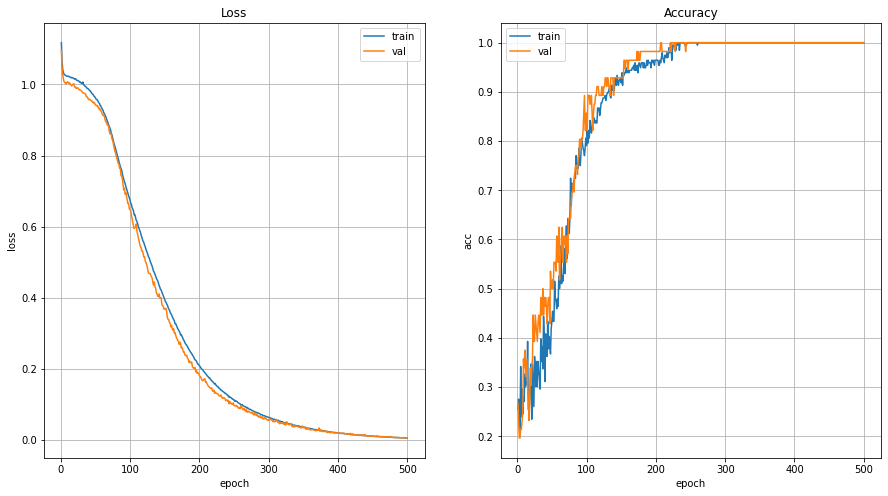

In [ ]:
plot_metrics(train_info1)

In [ ]:
print("Val accuracy =", train_info1.history['val_accuracy'][-1])

Val accuracy = 1.0


Получили очень идеальную точность на валидации.

Проверим, что происходит с тестовой выборкой.

In [ ]:
np.argmax(model1.predict(X_test, verbose=0), axis=1).shape

(28,)

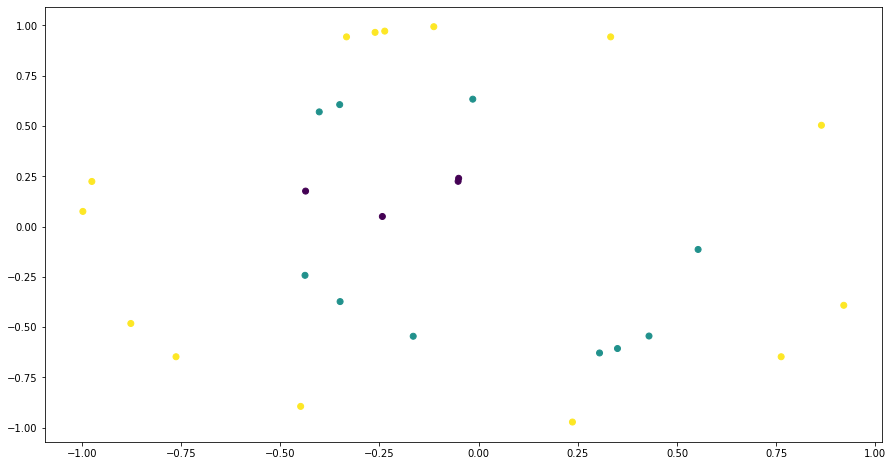

In [ ]:
plt.figure(figsize=(15, 8))

plt.scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(model1.predict(X_test, verbose=0), axis=1))

plt.show()

In [ ]:
print("Test accuracy =", (np.argmax(model1.predict(X_test, verbose=0), axis=1) == y_test).mean())

Test accuracy = 1.0


Все точки на эллипсах классифицированы верно.

Построим на классификацию точек во всей области

In [ ]:
h = 0.025

grid = [model1.predict(np.array([[i, j]]), verbose=0).round(1)
        for i in np.arange(-1.2, 1.2 + h, h)
        for j in np.arange(-1.2, 1.2 + h, h)]

In [ ]:
x_vals = np.arange(-1.2, 1.2 + h, h)
y_vals = np.arange(-1.2, 1.2 + h, h)

xx, yy = np.meshgrid(x_vals, y_vals)

In [ ]:
colors = np.array(grid).reshape((len(grid), 3))
colors.shape


(9409, 3)

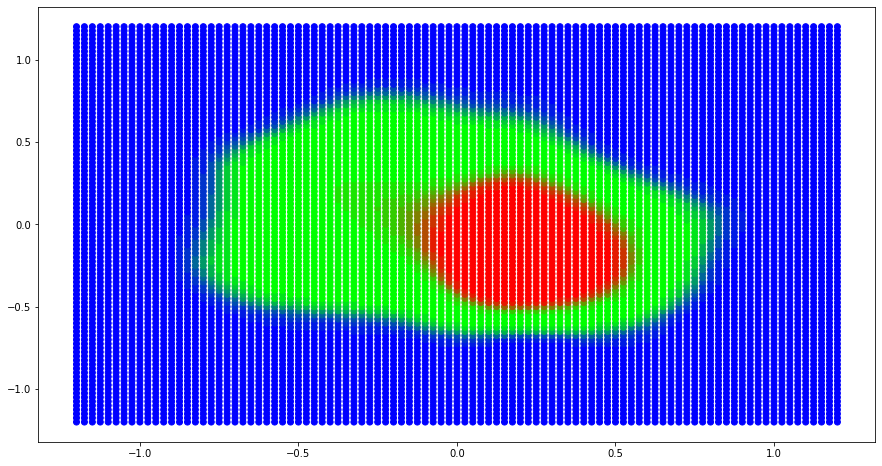

In [ ]:
plt.figure(figsize=(15, 8))

plt.scatter(xx, yy, c=colors)

plt.show()

Вырисовывается картинка, похожая на изначальный датасет с эллипсами

## Задание 2
Пробуем аппроксимировать функцию многослойной сетью с помощью методов первого порядка

In [ ]:
def fun(t):
    return np.sin(-2 * t**2 + 7*t)

range_t = (0, 3.5)
h = 0.01

Подготовим датасет:

In [ ]:
t = np.linspace(range_t[0], range_t[1], int((range_t[1] - range_t[0]) / h))
x = fun(t)

Поделим на трейн и вал

In [ ]:
train_len = int(t.shape[0] * 0.9)

t_train = t[:train_len]
t_val = t[train_len:]

x_train = x[:train_len]
x_val = x[train_len:]

In [ ]:
t_train = np.expand_dims(t_train, 1)
t_val = np.expand_dims(t_val, 1)

In [ ]:
t_train.shape, t_val.shape

((315, 1), (35, 1))

Обучим модель. В качестве алгоритма обучения возьмем Adam (метод оптимизации 1 порядка)

In [ ]:
model2 = keras.Sequential([
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1),
])

In [ ]:
model2.compile(
    loss='mse',
    optimizer='Adam',
    metrics=tf.keras.metrics.RootMeanSquaredError(),
)

In [ ]:
train_info2 = model2.fit(
    t_train,
    x_train,
    batch_size=4,
    epochs=2000,
    validation_data=(t_val, x_val),
    verbose=0
)


Посмотрим на лосс и метрики

In [ ]:
def plot_metrics2(train_info):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    loss_history = train_info.history['loss']
    val_loss_history = train_info.history['val_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
    plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    acc_history = train_info.history['root_mean_squared_error']
    val_acc_history = train_info.history['val_root_mean_squared_error']
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.plot(range(1, len(acc_history) + 1), acc_history, label='train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('RMSE')

    plt.show()

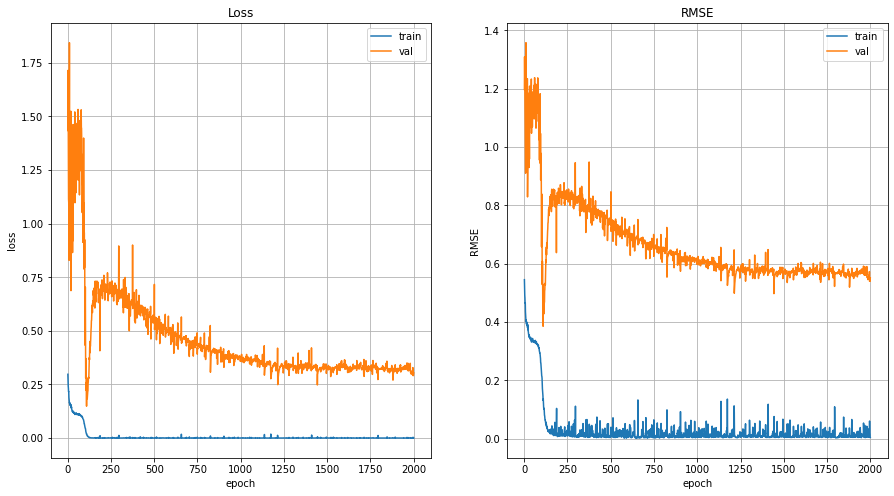

In [ ]:
plot_metrics2(train_info2)

In [ ]:
print("Val RMSE =", train_info2.history['val_root_mean_squared_error'][-1])

Val RMSE = 0.5515990257263184


Посмотрим на результаты на трейне

In [ ]:
def plot_results(model, t, fun):
    plt.figure(figsize=(15, 8))

    plt.plot(t, fun(t), label='true')
    plt.plot(t, model.predict(t), label='pred')

    plt.grid()
    plt.legend()
    plt.show()

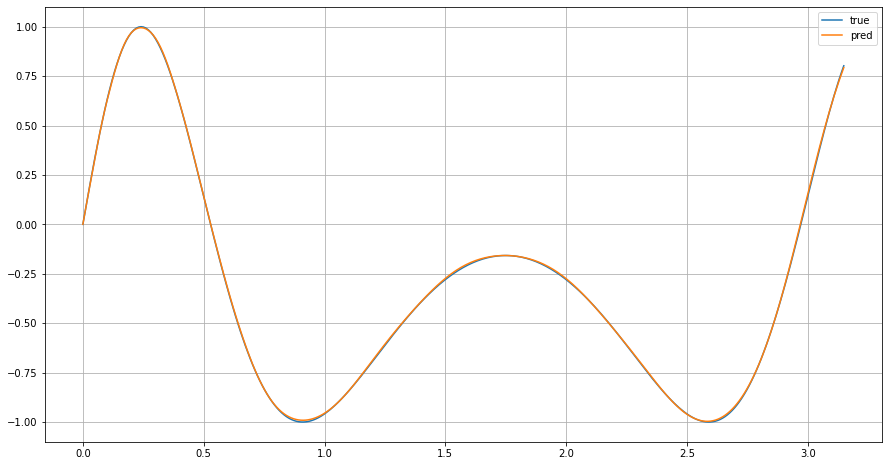

In [ ]:
plot_results(model2, t_train, fun)

И на вале

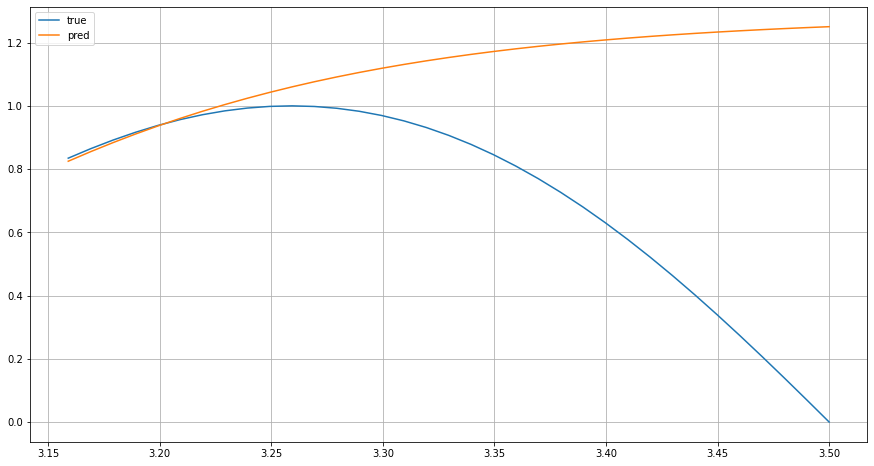

In [ ]:
plot_results(model2, t_val, fun)

С правой частью кривой (и с валидацией в том числе) модель справляется не очень хорошо

## Задание 3
Пробуем аппроксимировать функцию многослойной сетью с помощью методов второго порядка.

Так как в керасе нет методов оптимизации второго порядка, то перейдем на фреймворк neupy. В качестве алгоритма обучения будем использовать алгоритм Ньютона (метод второго порядка). Все остальное будет аналогично заданию 2

In [ ]:
!pip install neupy

In [ ]:
from neupy import algorithms, layers

In [ ]:
model3 = algorithms.Hessian(
    (
        layers.Input(1), 
        layers.Tanh(10),
        layers.Tanh(5),
        layers.Linear(1),
    ),
    verbose=True,
    show_epoch=1000,
)


Main information

[ALGORITHM] Hessian

[OPTION] loss = mse
[OPTION] penalty_const = 1
[OPTION] regularizer = None
[OPTION] show_epoch = 1000
[OPTION] shuffle_data = False
[OPTION] signals = None
[OPTION] target = Tensor("placeholder/target/linear-9:0", shape=(?, 1), dtype=float32)
[OPTION] verbose = True

[TENSORFLOW] Initializing Tensorflow variables and functions.
[TENSORFLOW] Initialization finished successfully. It took 1.39 seconds


In [ ]:
model3.train(t_train, x_train, t_val, x_val, epochs=15000)

#1 : [481 ms] train: 0.432621, valid: 9.036332


#1000 : [24 ms] train: 0.000328, valid: 2.081466


#2000 : [21 ms] train: 0.000166, valid: 1.823714


#3000 : [22 ms] train: 0.000119, valid: 1.655766


#4000 : [22 ms] train: 0.000097, valid: 1.561294


#5000 : [21 ms] train: 0.000085, valid: 1.491614


#6000 : [20 ms] train: 0.000076, valid: 1.435609


#7000 : [39 ms] train: 0.000069, valid: 1.388454


#8000 : [21 ms] train: 0.000063, valid: 1.347446


#9000 : [40 ms] train: 0.000058, valid: 1.311030


#10000 : [21 ms] train: 0.000053, valid: 1.278272


#11000 : [37 ms] train: 0.000049, valid: 1.248501


#12000 : [26 ms] train: 0.000045, valid: 1.221264


#13000 : [38 ms] train: 0.000041, valid: 1.196229


#14000 : [23 ms] train: 0.000038, valid: 1.173101


#15000 : [38 ms] train: 0.000035, valid: 1.151686


Проверим качество модели на трейне

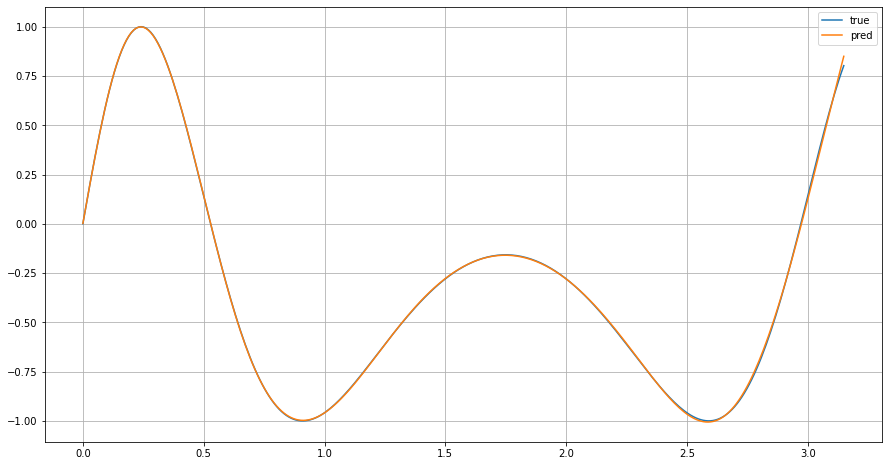

In [ ]:
plot_results(model3, t_train, fun)

И на вале

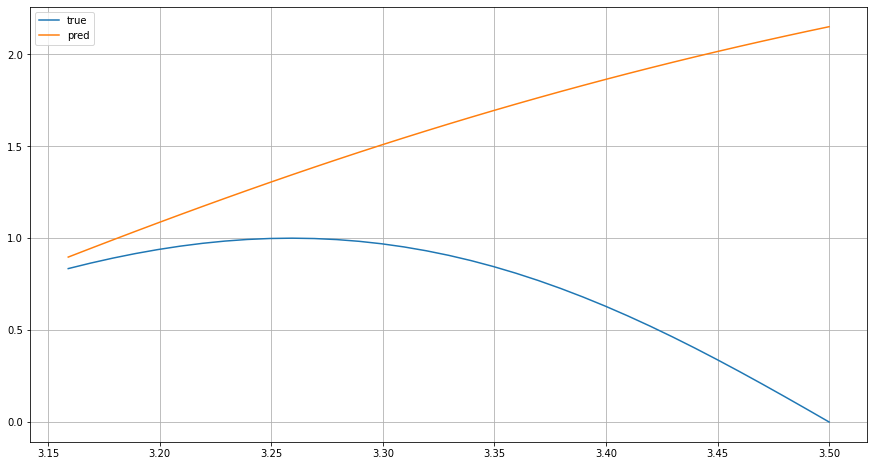

In [ ]:
plot_results(model3, t_val, fun)

In [ ]:
t_val_fl = t_val.flatten()
rmse_val = np.sqrt(np.mean((model3.predict(t_val).flatten() - fun(t_val_fl))**2))

print("Val RMSE =", rmse_val)

Val RMSE = 1.0731662522168999


Модель, обученная с помощью алгоритма второго порядка справилась с задачей чуть хуже, да и обучалась дольше

## Вывод

В этой работе я потренировался в работе с многослойными нейросетями. С их помощью я смог хорошо решить задачу классификации на 3 линейно неразделимых класса, а также попробовал аппроксимировать нелинейную функцию.

Для аппроксимации функции я воспользовался двумя алгоритмами обучения - Адам (метод первого порядка) и метод Ньютона (второго порядка). Метод второго порядка отработал хуже - он оказался более долгим и менее точным

Но нельзя сказать, что мы получили хороший результат. Ни одна модель не смогла начать закругление на валидационной выборке - все они продолжали строить функцию по прямой

```
RMSE на валидационном датасете:
адам: 0.55
метод ньютона: 1.07
```